In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mpu, math

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns

%matplotlib inline

In [2]:
bikes_df = pd.read_csv("metro-bike-share-trip-data.csv")
print(bikes_df.dtypes)
bikes_df.head()

Trip ID                         int64
Duration                        int64
Start Time                     object
End Time                       object
Starting Station ID           float64
Starting Station Latitude     float64
Starting Station Longitude    float64
Ending Station ID             float64
Ending Station Latitude       float64
Ending Station Longitude      float64
Bike ID                       float64
Plan Duration                 float64
Trip Route Category            object
Passholder Type                object
Starting Lat-Long              object
Ending Lat-Long                object
dtype: object


/Users/MikeBao/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
1,1919661,1980,2016-07-07T06:00:00,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
2,1933383,300,2016-07-07T10:32:00,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
3,1944197,10860,2016-07-07T10:37:00,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
4,1940317,420,2016-07-07T12:51:00,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04..."


In [3]:
bikes_df['Start Time'] = pd.to_datetime(bikes_df['Start Time'])
bikes_df['End Time'] = pd.to_datetime(bikes_df['End Time'])

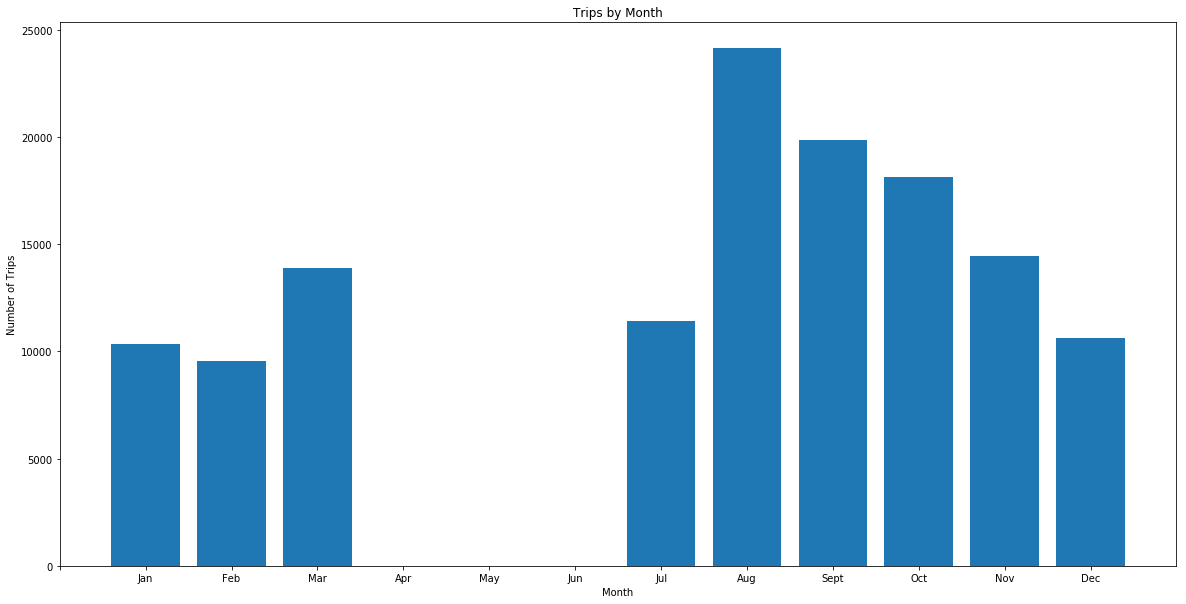

In [13]:
bikes_df['year'] = bikes_df['Start Time'].dt.month
bikes_df['month'] = bikes_df['Start Time'].dt.month
bikes_df['hour']= bikes_df['Start Time'].dt.hour
bymonth = bikes_df.groupby(['month']).aggregate('count')
plt.bar(bymonth.index, list(bymonth['Duration']))
plt.title("Trips by Month")
plt.ylabel("Number of Trips")
plt.xlabel("Month")
plt.xticks(np.arange(13), ["", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]);
# bikes_df['counts'] = bikes_df['casual'] + bikes_df['registered']

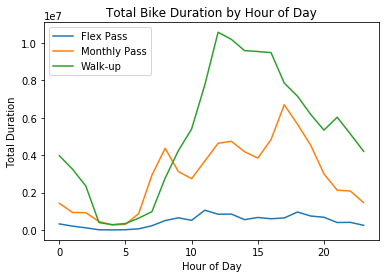

In [5]:
ploty = plt.axes()
holder_type = [[], [], [], []]
duration_hour = (bikes_df.groupby(['hour', 'Passholder Type'])["Duration"].aggregate('sum'))
for hr in range(24):
    holder_type[0].append(duration_hour[hr]['Flex Pass'])
    holder_type[1].append(duration_hour[hr]['Monthly Pass'])
#     holder_type[2].append(duration_hour[hr]['Staff Annual'])
    holder_type[2].append(duration_hour[hr]['Walk-up'])
ploty.plot(range(24), holder_type[0])
ploty.plot(range(24), holder_type[1])
ploty.plot(range(24), holder_type[2])
ploty.legend(['Flex Pass', 'Monthly Pass', 'Walk-up'])
ploty.set_xlabel('Hour of Day')
ploty.set_ylabel('Total Duration')
ploty.set_title('Total Bike Duration by Hour of Day');

Text(0.5,1,'Average Duration by Pass')

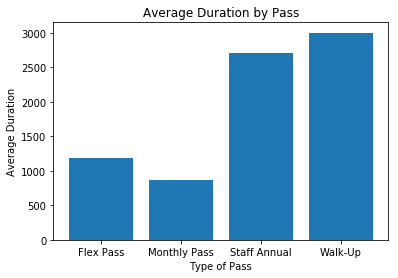

In [6]:
ploty = plt.axes()
mean_duration = bikes_df.groupby('Passholder Type')["Duration"].aggregate('mean')
ploty.bar(np.arange(4), bikes_df.groupby('Passholder Type')["Duration"].aggregate('mean'))
plt.xticks(np.arange(4), ('Flex Pass', 'Monthly Pass', 'Staff Annual', 'Walk-Up'))
ploty.set_xlabel('Type of Pass')
ploty.set_ylabel('Average Duration')
ploty.set_title('Average Duration by Pass')

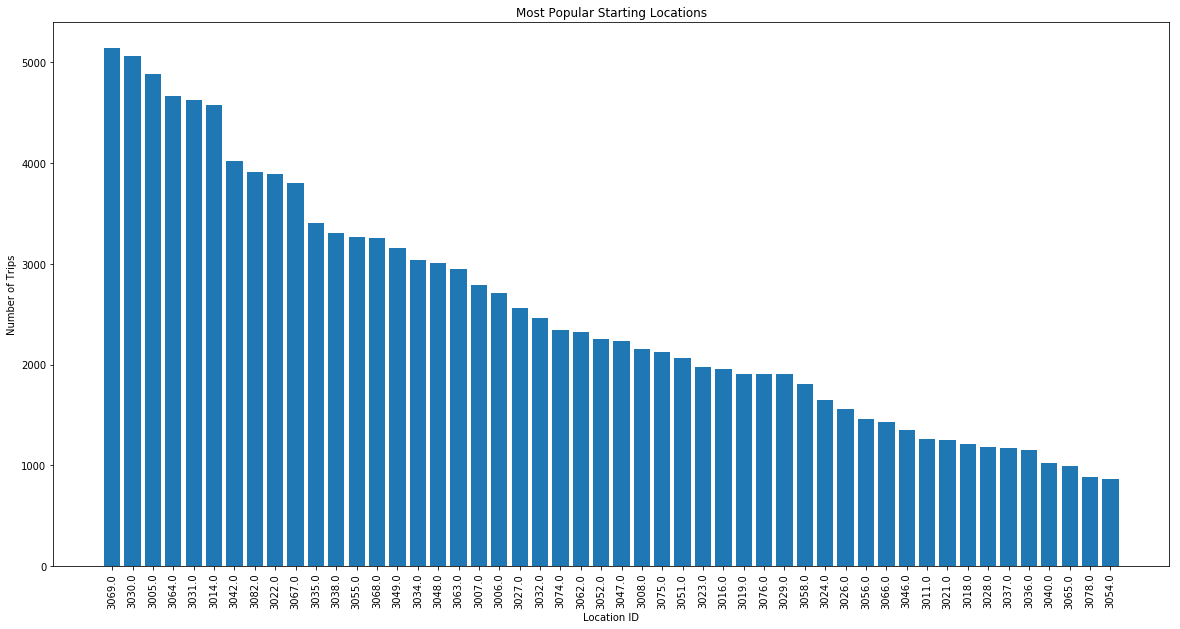

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
start_pop = bikes_df.groupby('Starting Station ID').aggregate('count')['Trip ID'].sort_values(ascending=False)
plt.bar(np.arange(50), list(start_pop)[:50])
xt = []
# for start in start_pop.index[:50]:
#      xt.append("Lat: %s, Long: %s" % (start.split("'")[3], start.split("'")[7]))
plt.xticks(np.arange(50), start_pop.index, rotation=90)
plt.title("Most Popular Starting Locations")
plt.xlabel("Location ID")
plt.ylabel("Number of Trips");

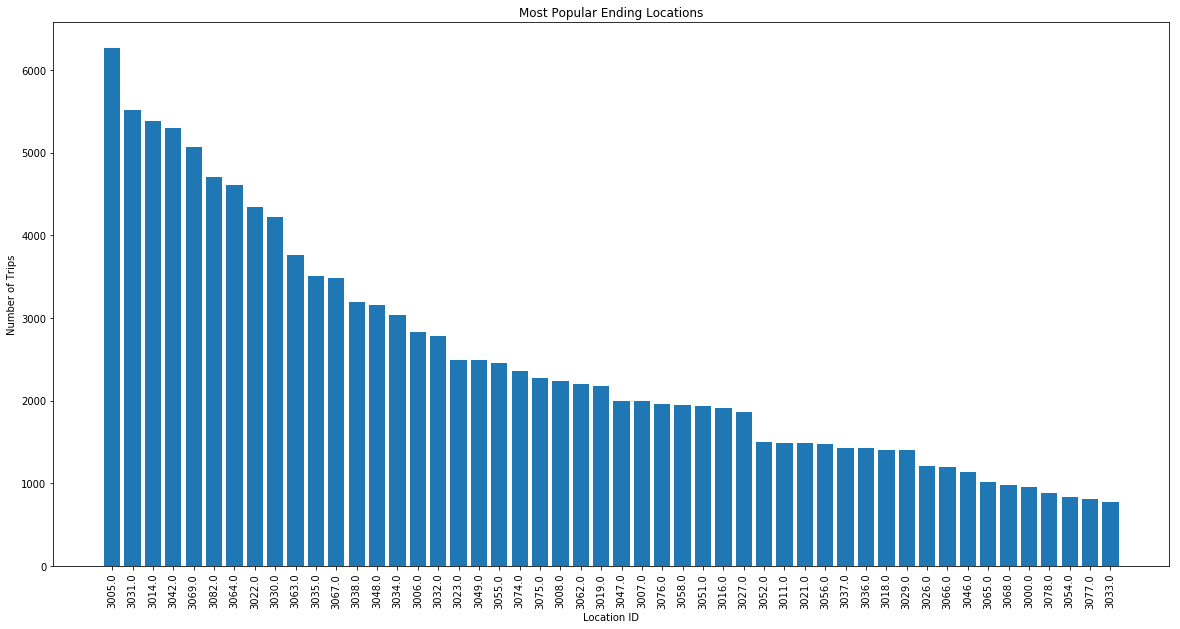

In [8]:
plt.rcParams["figure.figsize"] = (20,10)
start_pop = bikes_df.groupby('Ending Station ID').aggregate('count')['Trip ID'].sort_values(ascending=False)
plt.bar(np.arange(50), list(start_pop)[:50])
xt = []
# for start in start_pop.index[:50]:
#      xt.append("Lat: %s, Long: %s" % (start.split("'")[3], start.split("'")[7]))
plt.xticks(np.arange(50), start_pop.index, rotation=90)
plt.title("Most Popular Ending Locations")
plt.xlabel("Location ID")
plt.ylabel("Number of Trips");

In [19]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [20]:
import mpu
distances = []
for ind in bikes_df.index:
    distances.append(distance((float(bikes_df.loc[ind]['Starting Station Latitude']),
                                             float(bikes_df.loc[ind]['Starting Station Longitude'])), 
                                            (float(bikes_df.loc[ind]['Ending Station Latitude']), 
                                             float(bikes_df.loc[ind]['Ending Station Longitude']))))
print(distances)
    

[0.0, 0.0, 0.0, 0.0, 0.0, 0.7122311132528311, 1.2319276511611308, 1.0059150164765616, 0.0, 2.5074687678829592, 1.389163651830656, 0.5775782607320192, 0.5246504403843913, 0.0, 1.556238711727602, 0.47388248523162113, 0.5123575872849455, 0.9080301546289858, 0.5752705896871408, 2.5505474461765907, 1.351032600335444, 1.658328294123348, 0.4486392161810192, 1.658328294123348, 1.864138452000142, 0.5815698007345396, 2.0549743728136827, 1.351032600335444, 2.4916495823883755, 0.0, 1.2626332994328024, 1.2626332994328024, 0.0, 1.2681234570579947, 1.7552270420761744, 1.361074745129209, 0.0, 2.1534535302549207, 0.0, 1.6616427833193854, 0.22724781856617024, 2.1906633248497958, 2.5798898669646424, 0.7801009760749822, 0.210416187940595, 1.8137029717259723, 0.7801009760749822, 1.264061245748376, 1.781892615716845, 0.49347344108784824, 0.952965830263369, 3.0799782528045365, 3.0799782528045365, 1.8384883273925068, 0.0, 0.7801009760749822, 0.0, 1.0712847295471601, 1.0712847295471601, 0.9544061959780146, 0.9

In [39]:
ave = 0
for el in distances:
    if el >= 0:
        ave += el/len(distances)
print(ave)

4.855174690313979
